# Модель прогнозирования оттока клиентов Компании "ТелеДом"

    Оператор связи «ТелеДом» хочет бороться с оттоком клиентов. Для этого его сотрудники начнут предлагать промокоды и специальные условия всем, кто планирует отказаться от услуг связи. Чтобы заранее находить таких пользователей, «ТелеДому» нужна модель, которая будет предсказывать, разорвёт ли абонент договор. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и услугах. 
    Наша задача — обучить на этих данных модель для прогноза оттока клиентов.

## Шаг 1. Загрузка данных

In [1]:
!pip install phik==0.10.0 -q

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import pandas as pd

from sklearn.utils import shuffle

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from catboost import CatBoostClassifier
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, confusion_matrix
import sklearn.metrics as metrics
from time import time
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import plotly.express as px
from scipy.stats import binom, poisson
from math import factorial

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder, 
    StandardScaler, 
    MinMaxScaler,
    RobustScaler
)

from sklearn.impute import SimpleImputer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split, cross_val_score

import phik

from sklearn.metrics import make_scorer

from matplotlib.pyplot import figure
import matplotlib.pyplot as plt
plt.rcParams ['figure.figsize'] = [10, 4]

Задаю константы

In [4]:
RANDOM_STATE = 80424
CV_COUNTS = 5

Загружаю данные.

In [5]:
try:
    contract_new = pd.read_csv('C:/Users/almuc/Downloads/contract_new.csv', decimal = ',', parse_dates=['BeginDate', 'EndDate'], dayfirst=True)
    personal_new = pd.read_csv('C:/Users/almuc/Downloads/personal_new.csv', decimal = ',')
    internet_new = pd.read_csv('C:/Users/almuc/Downloads/internet_new.csv', decimal = ',')
    phone_new = pd.read_csv('C:/Users/almuc/Downloads/phone_new.csv', decimal = ',')
except:
    contract_new = pd.read_csv('/datasets/contract_new.csv', decimal = ',', parse_dates=['BeginDate', 'EndDate'], dayfirst=True)
    personal_new = pd.read_csv('/datasets/personal_new.csv', decimal = ',')
    internet_new = pd.read_csv('/datasets/internet_new.csv', decimal = ',')
    phone_new = pd.read_csv('/datasets/phone_new.csv', decimal = ',')

In [6]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [7]:
contract_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7043 non-null   object        
 1   BeginDate         7043 non-null   datetime64[ns]
 2   EndDate           7043 non-null   object        
 3   Type              7043 non-null   object        
 4   PaperlessBilling  7043 non-null   object        
 5   PaymentMethod     7043 non-null   object        
 6   MonthlyCharges    7043 non-null   object        
 7   TotalCharges      7043 non-null   object        
dtypes: datetime64[ns](1), object(7)
memory usage: 440.3+ KB


In [8]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


В таблице contract_new 7043 строк и 8 столбцов, пропусков нет. Таже в таблице contract_new содержатся информация о договоре.

In [9]:
personal_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [10]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


В таблице personal_new 7043 строк и 5 столбцов, пропусков нет. В таблице personal_new содержатся данные о пользователях и их составе семьи.

In [11]:
internet_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [12]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


В таблице internet_new 5517 строк и 8 столбцов, пропусков нет. В таблице internet_new содержаться данные о пользователях которые используют интернет и подключили дополнительные услуги.

In [13]:
phone_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


В таблице phone_new 6361 строк и 2 столбца, пропусков нет. В таблице phone_new содержаться данные о пользователях пользующихся телефонами и использующие подключение телефона к нескольким линиям одновременно.

## Шаг 2. Исследовательский анализ и предобработка данных

**Информация о договоре**

In [14]:
contract_new.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.3,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.7,353.5


In [15]:
contract_new.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges              object
TotalCharges                object
dtype: object

Нужно привести столбцы MonthlyCharges и TotalCharges к формату float32.

In [16]:
contract_new['MonthlyCharges'] = contract_new['MonthlyCharges'].astype('float32')

В столбце TotalCharges обнаружен пробел в данных. Посмотрим на эти данные.

In [17]:
contract_new_omissions = contract_new.loc[(contract_new['TotalCharges'] == " ")]
contract_new_omissions

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.549999,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.250000,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.849998,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.750000,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.049999,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.850000,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.350000,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.000000,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.700001,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.349998,


Строк всего 11, вполне логично, т.к. клиенты заключили договора в феврале 2020 года, а у нас данные на 01.02.2020 г. Следовательно клиенты новые и еще ни разу не успели заплатить за услуги связи. Эти данные удалим.

In [18]:
contract_new = contract_new.loc[(contract_new['TotalCharges'] != " ")]

In [19]:
contract_new['TotalCharges'] = contract_new['TotalCharges'].astype('float32')

In [20]:
contract_new.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate                     object
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float32
TotalCharges               float32
dtype: object

Проверим уникальность заполненых данных.

In [21]:
contract_new.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges'],
      dtype='object')

In [22]:
contract_new['Type'].unique()

array(['Month-to-month', 'One year', 'Two year'], dtype=object)

In [23]:
contract_new['PaperlessBilling'].unique()

array(['Yes', 'No'], dtype=object)

In [24]:
contract_new['PaymentMethod'].unique()

array(['Electronic check', 'Mailed check', 'Bank transfer (automatic)',
       'Credit card (automatic)'], dtype=object)

In [25]:
contract_new['MonthlyCharges'].unique()

array([29.85, 56.95, 53.85, ..., 63.1 , 44.2 , 78.7 ], dtype=float32)

In [26]:
contract_new['TotalCharges'].unique()

array([  31.04, 2071.84,  226.17, ...,  325.6 ,  520.8 , 7251.82],
      dtype=float32)

Ошибок в данных больше не вижу. Оставим пока как есть.

**Персональные данные клиента**

In [27]:
personal_new.head()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


In [28]:
personal_new.dtypes

customerID       object
gender           object
SeniorCitizen     int64
Partner          object
Dependents       object
dtype: object

In [29]:
personal_new.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents'], dtype='object')

In [30]:
personal_new['gender'].unique()

array(['Female', 'Male'], dtype=object)

In [31]:
personal_new['SeniorCitizen'].unique()

array([0, 1], dtype=int64)

In [32]:
personal_new['Partner'].unique()

array(['Yes', 'No'], dtype=object)

In [33]:
personal_new['Dependents'].unique()

array(['No', 'Yes'], dtype=object)

В данных не наблюдаются ошибки. Типы данных верные.

**Информация об интернет-услугах**

In [34]:
internet_new.head()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


In [35]:
internet_new.dtypes

customerID          object
InternetService     object
OnlineSecurity      object
OnlineBackup        object
DeviceProtection    object
TechSupport         object
StreamingTV         object
StreamingMovies     object
dtype: object

In [36]:
internet_new.columns

Index(['customerID', 'InternetService', 'OnlineSecurity', 'OnlineBackup',
       'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'],
      dtype='object')

In [37]:
internet_new['InternetService'].unique()

array(['DSL', 'Fiber optic'], dtype=object)

In [38]:
internet_new['OnlineSecurity'].unique()

array(['No', 'Yes'], dtype=object)

In [39]:
internet_new['OnlineBackup'].unique()

array(['Yes', 'No'], dtype=object)

In [40]:
internet_new['DeviceProtection'].unique()

array(['No', 'Yes'], dtype=object)

In [41]:
internet_new['TechSupport'].unique()

array(['No', 'Yes'], dtype=object)

In [42]:
internet_new['StreamingTV'].unique()

array(['No', 'Yes'], dtype=object)

In [43]:
internet_new['StreamingMovies'].unique()

array(['No', 'Yes'], dtype=object)

Типы данных верные, ошибок в заполнении нет.

**Информация об услугах телефонии**

In [44]:
phone_new.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [45]:
phone_new.dtypes

customerID       object
MultipleLines    object
dtype: object

In [46]:
phone_new['MultipleLines'].unique()

array(['No', 'Yes'], dtype=object)

Типы данных верные, ошибок не выявлено.

**Вывод**

После загрузки данных было выявлено следующее:
- В информации о договоре:
    - Столбцы MonthlyCharges и TotalCharges были приведены к формату float32. При этом в столбце TotalCharges были выявлены пробелы. Данные пробелы образовались из-за того, что клиенты только пришли и не успели заплатить за услуги связи. Такх строк было 11 и они были удалены из данных.
    - все данные уникальные, ошибок в заполнении граф не выявлено.
- В персональных данных клиента ошибки в заполнении граф не выявлены.
- В информации об интернет-услугах ошибок в заполнении не выявлено.
- В информации об услугах телефонии также ошибок в заполнении данных не выявлено.

## Шаг 3. Объединение данных

In [47]:
data = contract_new.merge(personal_new, on ='customerID', how='left')

In [48]:
data = data.merge(internet_new, on ='customerID', how='left')

In [49]:
data = data.merge(phone_new, on ='customerID', how='left')

In [50]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


In [51]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7032 entries, 0 to 7031
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        7032 non-null   object        
 1   BeginDate         7032 non-null   datetime64[ns]
 2   EndDate           7032 non-null   object        
 3   Type              7032 non-null   object        
 4   PaperlessBilling  7032 non-null   object        
 5   PaymentMethod     7032 non-null   object        
 6   MonthlyCharges    7032 non-null   float32       
 7   TotalCharges      7032 non-null   float32       
 8   gender            7032 non-null   object        
 9   SeniorCitizen     7032 non-null   int64         
 10  Partner           7032 non-null   object        
 11  Dependents        7032 non-null   object        
 12  InternetService   5512 non-null   object        
 13  OnlineSecurity    5512 non-null   object        
 14  OnlineBackup      5512 n

Данные объеденены без потерь получилось 7032 строк и 20 столбцов.

**Вывод**

Мы произвели объедение данных, к таблице с данными о договорах, где были удалены строки с пробелами, были присоеденены данные о клиентах, интернет услугах и многоканальности телефонной линии. Данные объедены без потерь получилось 7032 строк и 20 столбцов. Появились пропуски данных.

## Шаг 4. Исследовательский анализ и предобработка данных объединённого датафрейма

Проверим на наличие пропусков.

In [52]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
InternetService     1520
OnlineSecurity      1520
OnlineBackup        1520
DeviceProtection    1520
TechSupport         1520
StreamingTV         1520
StreamingMovies     1520
MultipleLines        680
dtype: int64

In [53]:
data.columns

Index(['customerID', 'BeginDate', 'EndDate', 'Type', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'gender',
       'SeniorCitizen', 'Partner', 'Dependents', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'MultipleLines'],
      dtype='object')

Думаю, что пропуски в столбцах 'InternetService','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' образовались по очень простой причине: "Не все пользователи пользуются всеми предоставленными услугами". Поэтому во всех столбцах поставим "No".

In [54]:
#data['InternetService'] = data['InternetService'].fillna('No')

In [55]:
#data['OnlineSecurity'] = data['OnlineSecurity'].fillna('No')

In [56]:
#data['OnlineBackup'] = data['OnlineBackup'].fillna('No')

In [57]:
#data['DeviceProtection'] = data['DeviceProtection'].fillna('No')

In [58]:
#data['TechSupport'] = data['TechSupport'].fillna('No')

In [59]:
#data['StreamingTV'] = data['StreamingTV'].fillna('No')

In [60]:
#data['StreamingMovies'] = data['StreamingMovies'].fillna('No')

In [61]:
#data['MultipleLines'] = data['MultipleLines'].fillna('No')

In [62]:
data = data.fillna('No')

Проверяем, что получилось в итоге.

In [63]:
data.isna().sum()

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
MultipleLines       0
dtype: int64

Отлично, пропусков больше нет.

Проверяем на наличие дубликатов.

In [64]:
print('Количество явных дубликатов в объединенных данных', data.duplicated().sum())

Количество явных дубликатов в объединенных данных 0


Дубликатов нет.

In [65]:
data.describe()

,MonthlyCharges,TotalCharges,SeniorCitizen
count,7032.000000,7032.000000,7032.000000
mean,64.798210,2118.621826,0.162400
std,30.085974,2112.736084,0.368844
min,18.250000,19.049999,0.000000
25%,35.587499,439.745010,0.000000
50%,70.349998,1345.274963,0.000000
75%,89.862499,3239.317566,0.000000
max,118.750000,9221.379883,1.000000


Данные распределены нормально. визуально выбросов не наблюдаю.

Как я понимаю нужно создать колонку с целевым признаком прекратил ли клиент договор с компанией. Для этого введем столбец target. Где 1 означает, что клиент расторгнул договор, а 0 клиент остался.

In [66]:
data['target'] = data['EndDate'].apply(lambda x: 0 if x == 'No' else 1)

In [67]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.950001,2071.840088,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,0
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,0
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,0


Нужно расчитать количество дней пользования интернетом, для этого мы заменим в столбце EndDate значения 'No' на '2020-02-01'. Так как наши данные по условию задачи даны на 01.02.2020 г.

In [68]:
data['EndDate'].replace('No', '2020-02-01', inplace=True)

In [69]:
data['EndDate'] = pd.to_datetime(data['EndDate'])

Добавим новый столбец с количеством дней обслуживания.

In [70]:
data['days'] = data['EndDate']- data['BeginDate']

In [71]:
data['days'] = data['days'].dt.days

In [72]:
data.dtypes

customerID                  object
BeginDate           datetime64[ns]
EndDate             datetime64[ns]
Type                        object
PaperlessBilling            object
PaymentMethod               object
MonthlyCharges             float32
TotalCharges               float32
gender                      object
SeniorCitizen                int64
Partner                     object
Dependents                  object
InternetService             object
OnlineSecurity              object
OnlineBackup                object
DeviceProtection            object
TechSupport                 object
StreamingTV                 object
StreamingMovies             object
MultipleLines               object
target                       int64
days                         int64
dtype: object

In [73]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950001,2071.840088,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


Новые столбцы добавлены, типы данных верные.

В первую очередь, думаю надо посмотреть на распределение целевого признака.

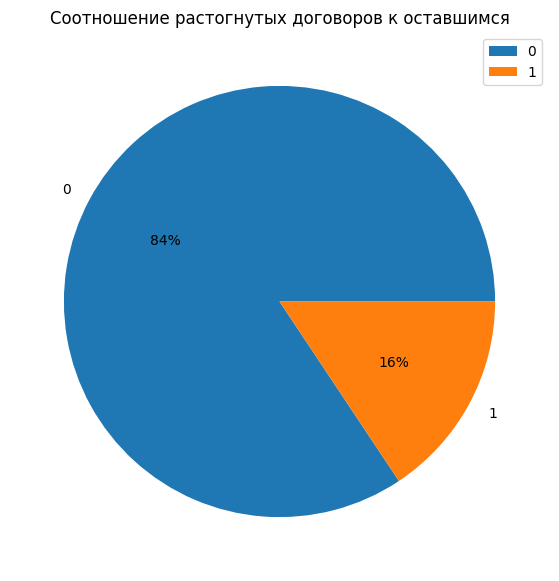

In [74]:
data.pivot_table(index='target',values='customerID',aggfunc='count') \
  .plot.pie(y='customerID', figsize=(10,7), label='', autopct='%1.0f%%')
plt.title("Соотношение растогнутых договоров к оставшимся")
plt.show()

16 % клиентов растогрнули договор обслуживания, в компании правы нужно проводить с этим работу.

Для того, чтобы провести правильный анализ клиентов прекративших договор, нужно разделить наши данные на 2: те кто ушел и те кто остался.

In [75]:
finished = data.loc[(data['target'] == 1)]
finished.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days
9,6388-TABGU,2014-12-01,2017-05-01,One year,No,Bank transfer (automatic),56.150002,1628.349976,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,1,882
15,3655-SNQYZ,2014-05-01,2016-03-01,Two year,No,Credit card (automatic),113.250000,2491.500000,Female,0,...,Fiber optic,Yes,Yes,Yes,Yes,Yes,Yes,Yes,1,670
25,6865-JZNKO,2017-08-01,2018-09-01,Month-to-month,Yes,Bank transfer (automatic),55.299999,726.090027,Female,0,...,DSL,Yes,Yes,No,No,No,No,No,1,396
30,3841-NFECX,2014-03-01,2018-11-01,Two year,Yes,Credit card (automatic),96.349998,5395.600098,Female,1,...,Fiber optic,Yes,Yes,Yes,Yes,No,No,Yes,1,1706
35,6234-RAAPL,2014-02-01,2018-12-01,Two year,No,Bank transfer (automatic),99.900002,5794.200195,Female,0,...,Fiber optic,Yes,Yes,No,Yes,Yes,No,Yes,1,1764


In [76]:
finished.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1101 entries, 9 to 7023
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        1101 non-null   object        
 1   BeginDate         1101 non-null   datetime64[ns]
 2   EndDate           1101 non-null   datetime64[ns]
 3   Type              1101 non-null   object        
 4   PaperlessBilling  1101 non-null   object        
 5   PaymentMethod     1101 non-null   object        
 6   MonthlyCharges    1101 non-null   float32       
 7   TotalCharges      1101 non-null   float32       
 8   gender            1101 non-null   object        
 9   SeniorCitizen     1101 non-null   int64         
 10  Partner           1101 non-null   object        
 11  Dependents        1101 non-null   object        
 12  InternetService   1101 non-null   object        
 13  OnlineSecurity    1101 non-null   object        
 14  OnlineBackup      1101 n

In [77]:
stayed = data.loc[(data['target'] != 1)]
stayed.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950001,2071.840088,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


In [78]:
stayed.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5931 entries, 0 to 7031
Data columns (total 22 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerID        5931 non-null   object        
 1   BeginDate         5931 non-null   datetime64[ns]
 2   EndDate           5931 non-null   datetime64[ns]
 3   Type              5931 non-null   object        
 4   PaperlessBilling  5931 non-null   object        
 5   PaymentMethod     5931 non-null   object        
 6   MonthlyCharges    5931 non-null   float32       
 7   TotalCharges      5931 non-null   float32       
 8   gender            5931 non-null   object        
 9   SeniorCitizen     5931 non-null   int64         
 10  Partner           5931 non-null   object        
 11  Dependents        5931 non-null   object        
 12  InternetService   5931 non-null   object        
 13  OnlineSecurity    5931 non-null   object        
 14  OnlineBackup      5931 n

Данные не потеряны. продолжим исследование.

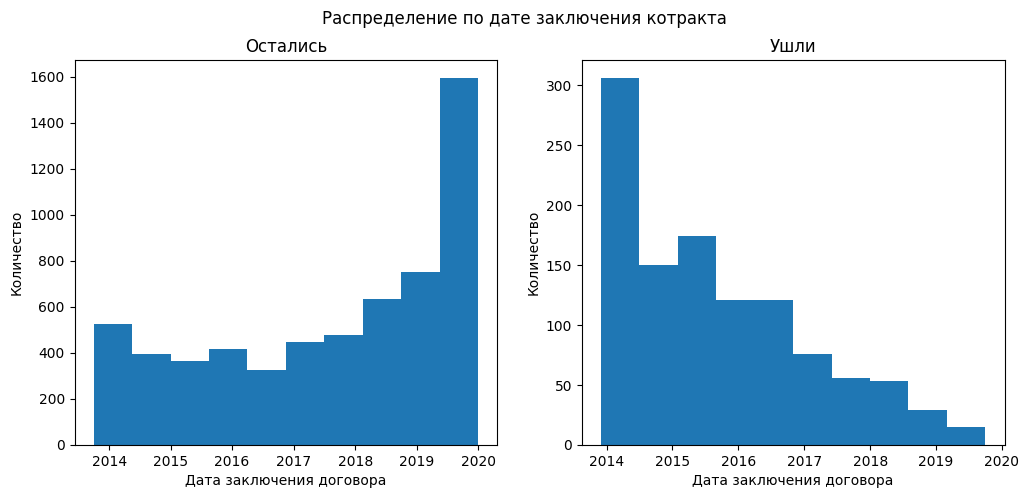

In [79]:
plt.subplots(figsize=(12, 5))
plt.suptitle('Распределение по дате заключения котракта')

plt.subplot(1, 2, 1)
plt.hist(stayed['BeginDate'])
plt.title('Остались')
plt.xlabel('Дата заключения договора')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(finished['BeginDate'])
plt.title('Ушли')
plt.xlabel('Дата заключения договора')
plt.ylabel('Количество')

plt.show()

    Наблюдается очень плохая динамика, ушли в первую очередь клиенты заключившие договора в 2014 года, при этом большинство ушедших клиентов  пользовались услугами связи с 2014 по 2017 год. Возможно это связано с устареванием оборудования у этих клиентов и ухудшением связи.
    Остались же большинство новых клиентов, заключивших договора 2019-2020 годы. Думаю это связано с какой-то рекламной акцией. Также не стоит забывать внешние факторы в этот момент, такие как пандемия и перевод сотрудников на удаленную работу.
    Нужно связаться с клиентом для уточнения этих предположений.

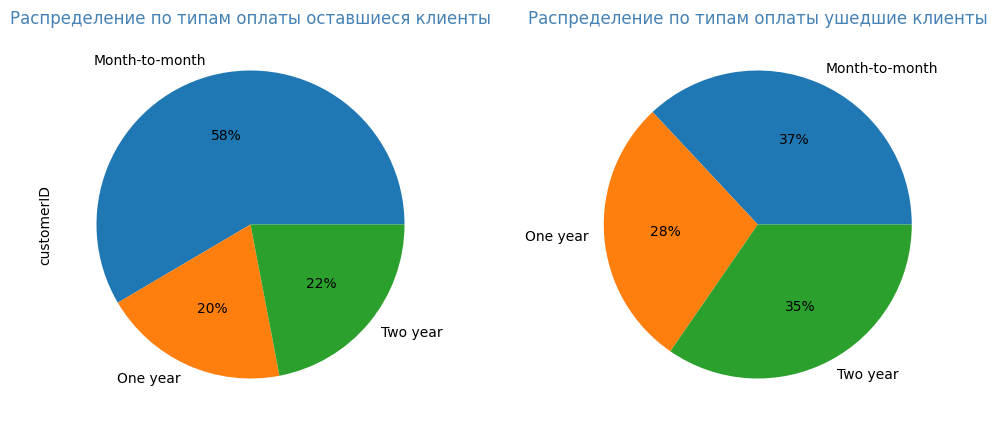

In [80]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('Type')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Распределение по типам оплаты оставшиеся клиенты',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('Type')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Распределение по типам оплаты ушедшие клиенты',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

В распределении по типам оплаты наблюдается следующее:
- Ушли одинаково клиенты с оплатами ежемесячно, раз в год и раз в два года.
- Остались большинство клиенты с оплатой ежемесячно.

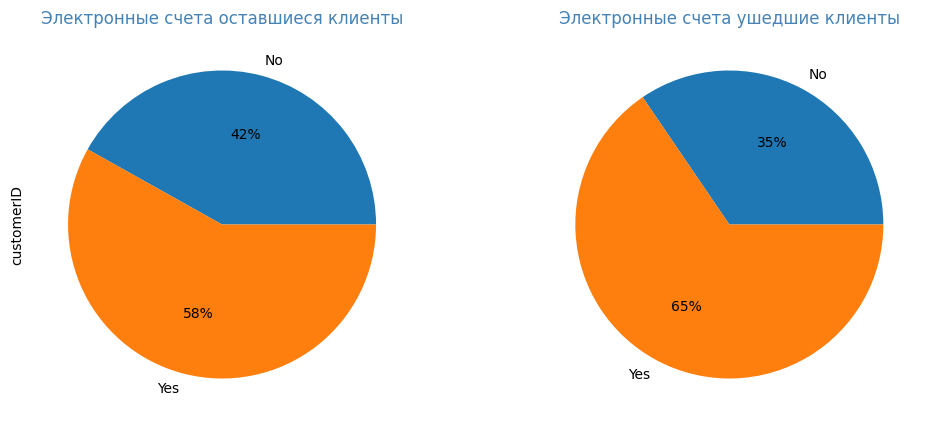

In [81]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('PaperlessBilling')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Электронные счета оставшиеся клиенты',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('PaperlessBilling')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Электронные счета ушедшие клиенты',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Получатели электронных счетов примерно поровну распределились для оставшихся клиентов и ушедших.

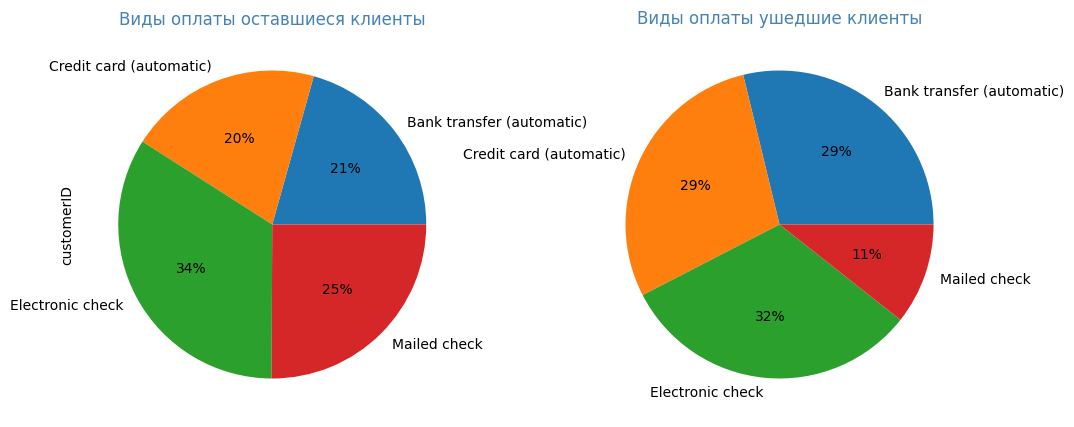

In [82]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('PaymentMethod')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Виды оплаты оставшиеся клиенты',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('PaymentMethod')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Виды оплаты ушедшие клиенты',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Виды оплаты счетов распределились следующим образом:
- Большиство оставшихся клиентов предпочитают оплату по электронному чеку их доля составляет 34 %, второе место занимает оплата по почте 25 % от общего числа.
- У ушедших клиентов также большинство предпочитает оплату по электронному чеку их доля составляет 32 %, в то же время на втором месте расположились оплаты по кредитным и банковским картам с долей 29 % каждый. Оплата по почте занимает 11 %. Думаю это доказывает теорию выше, ушедшие клиенты более продвинуты и пользуются технологическими преимуществами, и их вероятно не устраивает текущие возможности связи провайдера.

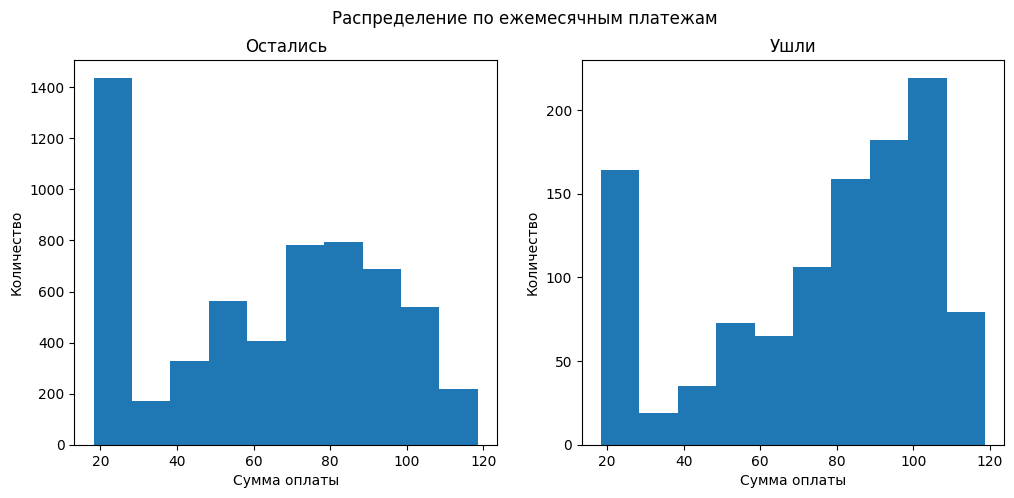

In [83]:
plt.subplots(figsize=(12, 5))
plt.suptitle('Распределение по ежемесячным платежам')

plt.subplot(1, 2, 1)
plt.hist(stayed['MonthlyCharges'])
plt.title('Остались')
plt.xlabel('Сумма оплаты')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(finished['MonthlyCharges'])
plt.title('Ушли')
plt.xlabel('Сумма оплаты')
plt.ylabel('Количество')

plt.show()

По ежемесячным платежам можно сказать следующее:
- Наблюдается 2 пика по платежам у ушедших и оставшихся клиентов 20-30 и 80-100. Вероятно это связано с такифами заказчика.
- Остались большинство клиетов с минимальной оплатой.
- Ушли большинство клиентов с максимальной оплатой. Возможно на рынке появился конкурент, предлагающий те же услуги но дешевле, если это так, то стоит над этим подумать. Нужно обратиться в отдел маркетинга заказчика.

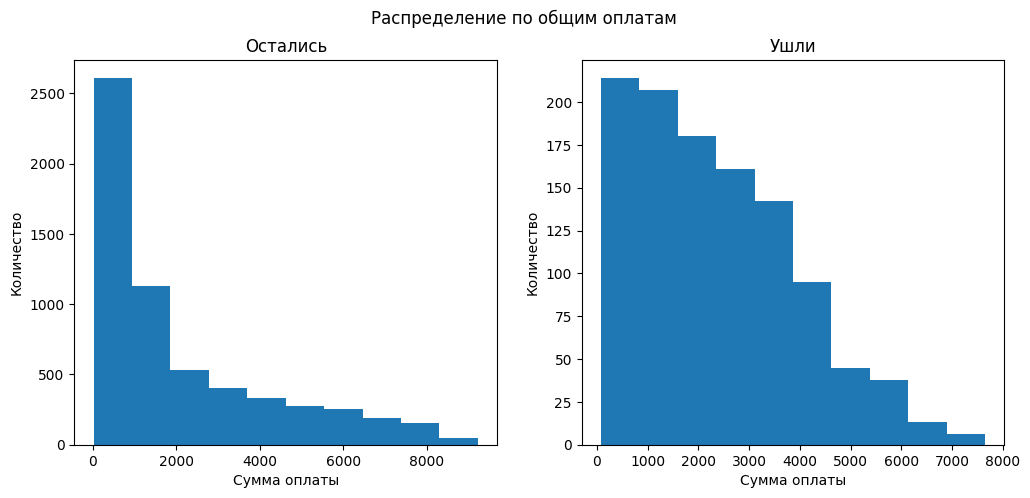

In [84]:
plt.subplots(figsize=(12, 5))
plt.suptitle('Распределение по общим оплатам')

plt.subplot(1, 2, 1)
plt.hist(stayed['TotalCharges'])
plt.title('Остались')
plt.xlabel('Сумма оплаты')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(finished['TotalCharges'])
plt.title('Ушли')
plt.xlabel('Сумма оплаты')
plt.ylabel('Количество')

plt.show()

По общим платежам наблюдается явная тенденция, остались клиенты которые заплатили до 2000. Ранее же писал, что большинство ушло большинство "старых" клиентов. А за большой период и сумма будет больше. 

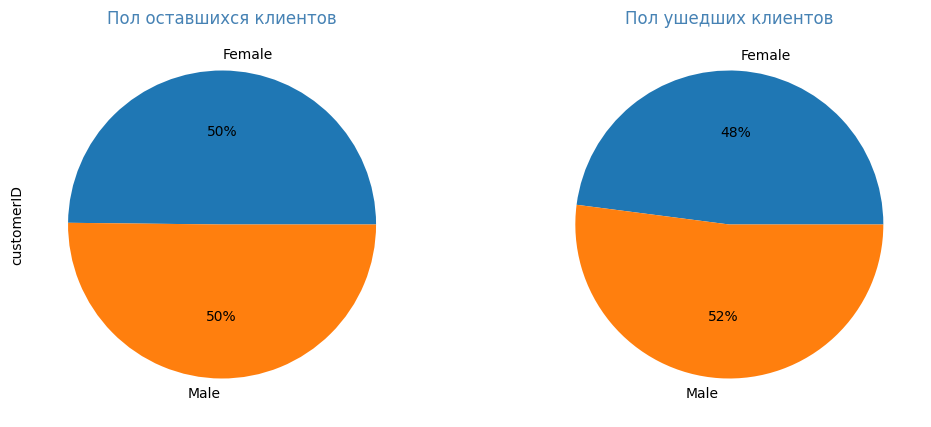

In [85]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('gender')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Пол оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('gender')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Пол ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Не наблюдается особой тенденции в различии по полу клиентов, примерно одинаково мужчин и женщин остались и также ушло.

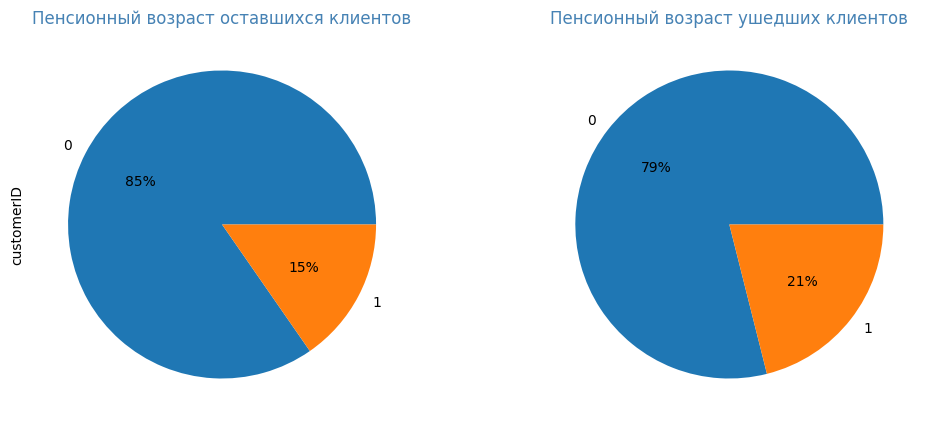

In [86]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('SeniorCitizen')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Пенсионный возраст оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('SeniorCitizen')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Пенсионный возраст ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

По возрасту видно следующее:
- среди оставшихся клиентов 15 % пенсионеры,
- среди ушедших клиентов 21 % пенсионеров.

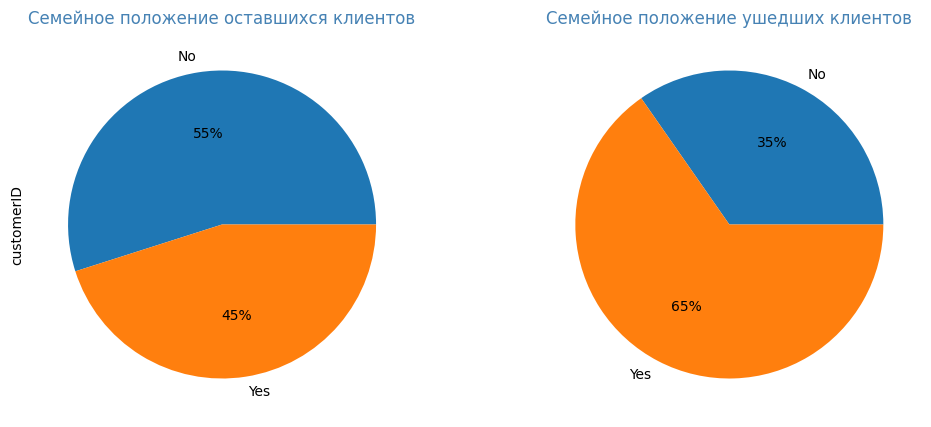

In [87]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('Partner')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Семейное положение оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('Partner')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Семейное положение ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

По семейному положению выявлено следующее:
- среди оставшихся клиентов 55 % не состоят в браке.
- а среди ушедших клиентов 65 % в браке, думаю стоит над этим подумать и предложить семейным какие-то особые условия или бонусную программу.

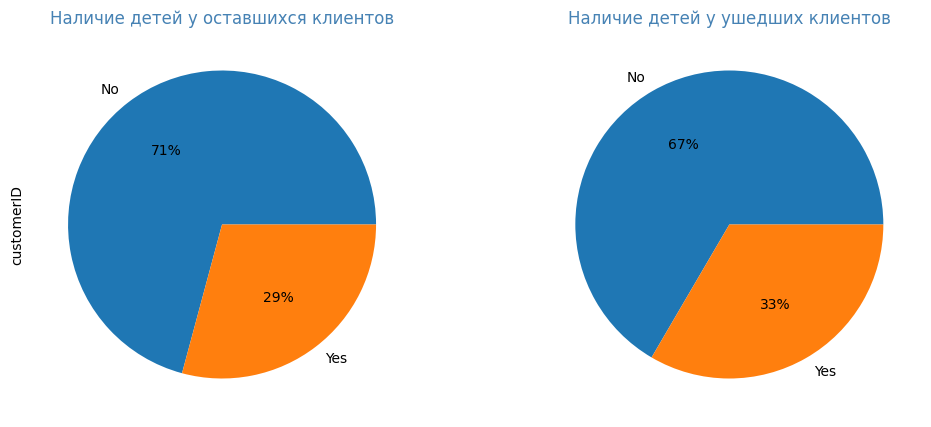

In [88]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('Dependents')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Наличие детей у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('Dependents')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Наличие детей у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

По наличию детей у клиентов особой разницы не наблюдается, у 29 % оставшихся клиентов есть дети, и у 33 % ушедших тоже есть дети.

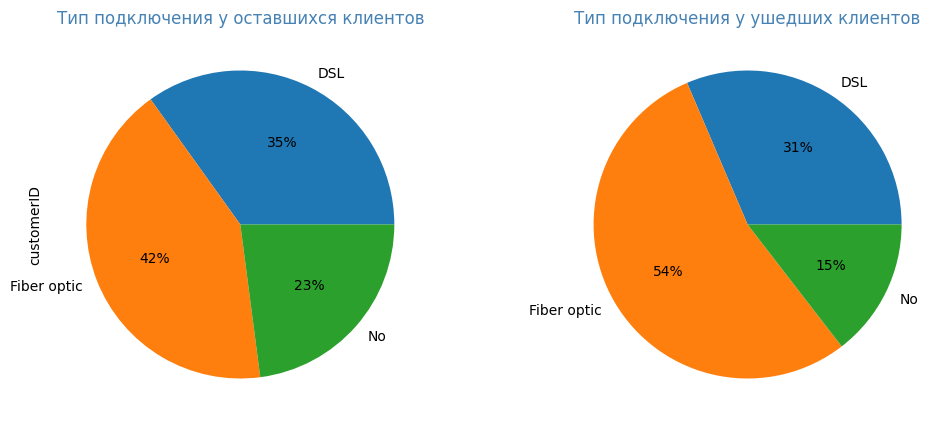

In [89]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('InternetService')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Тип подключения у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('InternetService')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Тип подключения у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Не все клиенты пользуются подключением, появилась новая категория не пользующуюся услугами связи. Возможно эти клиенты пользуются интернет услугами заказчиками, в то же время как они пользуются услугами связи другого провайдера. Стоит обратить на этих клиентов внимание и предложить свои услуги связи. Таже замечено, что большинство ушедших клиентов пользуется оптической связью и они составляют 54 % от общего количества ушедших клиентов.

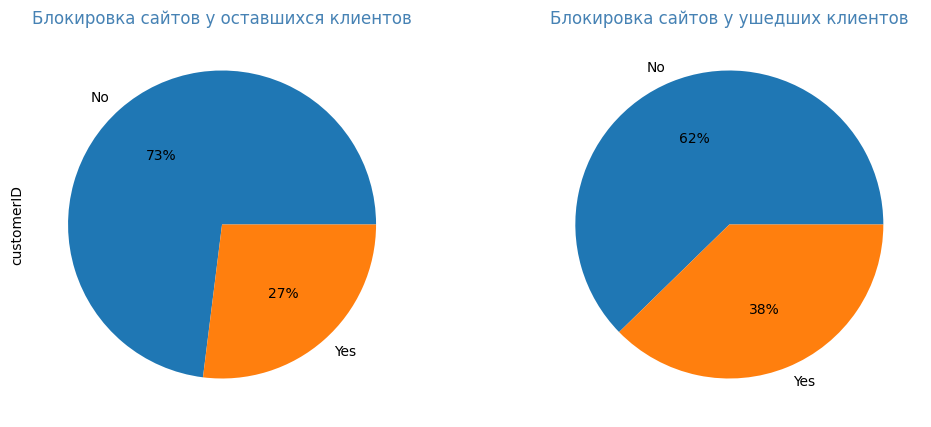

In [90]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('OnlineSecurity')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Блокировка сайтов у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('OnlineSecurity')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Блокировка сайтов у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Блокировка вредоносных сайтов подключена у 27 % оставшихся клиентов и у 38 % ушедших клиентов.

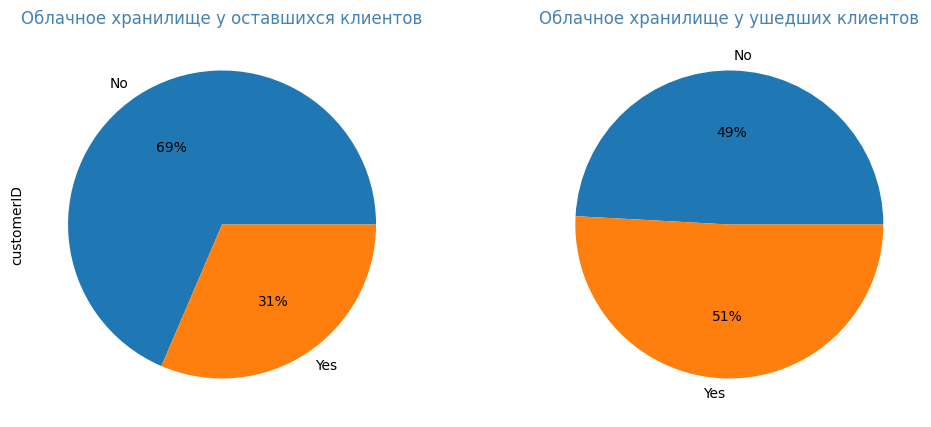

In [91]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('OnlineBackup')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Облачное хранилище у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('OnlineBackup')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Облачное хранилище у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Облачное хранилище подключено у 51 % ушедших клиентов и у 31 % оставшихся клиентов.

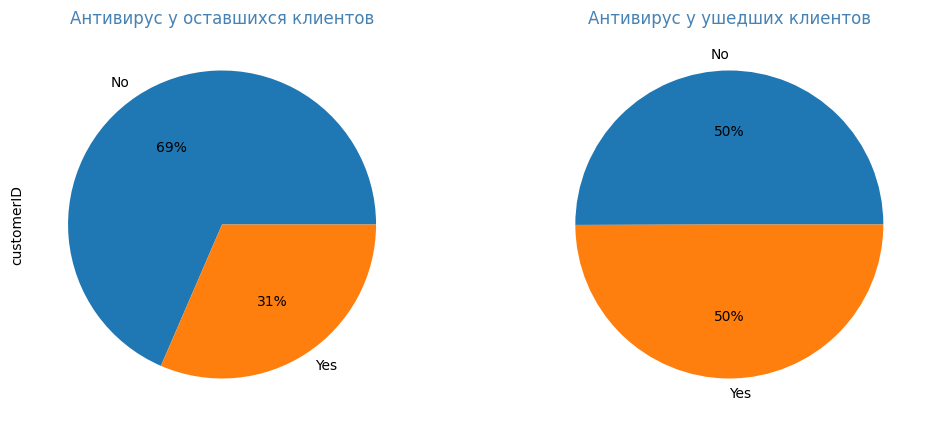

In [92]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('DeviceProtection')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Антивирус у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('DeviceProtection')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Антивирус у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Антивирус подключен у 50 % ушедших клиентов и у 31 % оставшихся клиентов.

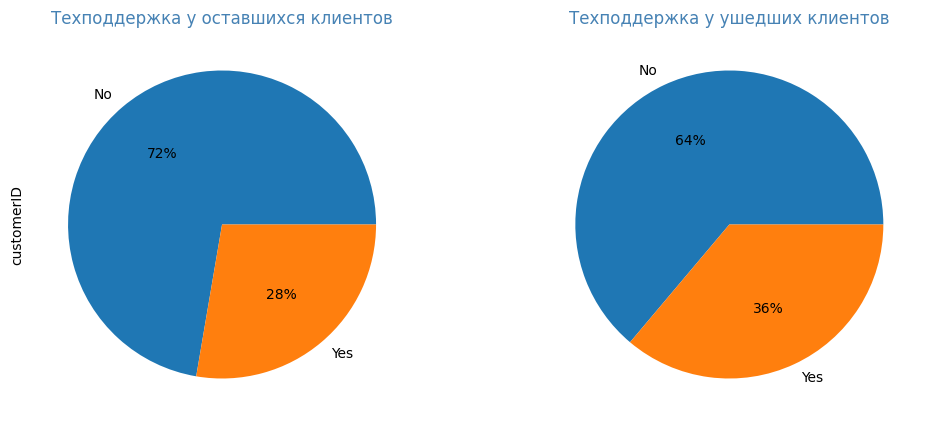

In [93]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('TechSupport')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Техподдержка у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('TechSupport')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Техподдержка у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Выделенная линия техподдержки подключена у 36 % ушедших клиентов и у 28 % оставшихся.

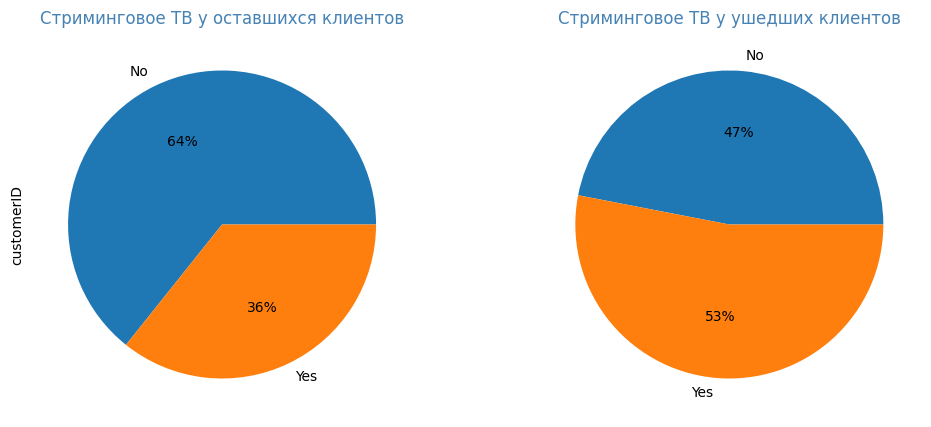

In [94]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('StreamingTV')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Стриминговое ТВ у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('StreamingTV')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Стриминговое ТВ у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Стриминговое ТВ водключено у 53 % ушедших клиентов и у 36 % оставшихся.

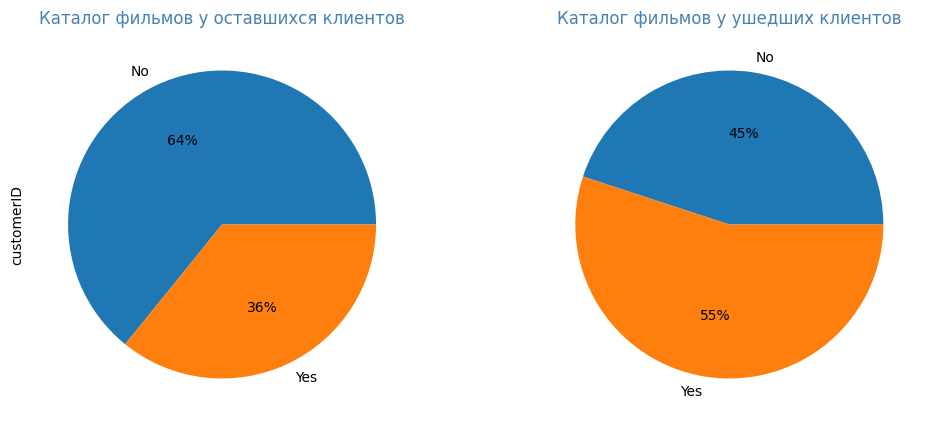

In [95]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('StreamingMovies')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Каталог фильмов у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('StreamingMovies')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Каталог фильмов у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Каталог фильмов подключен у 55 % ушедших клиентов и у 36 % оставшихся.

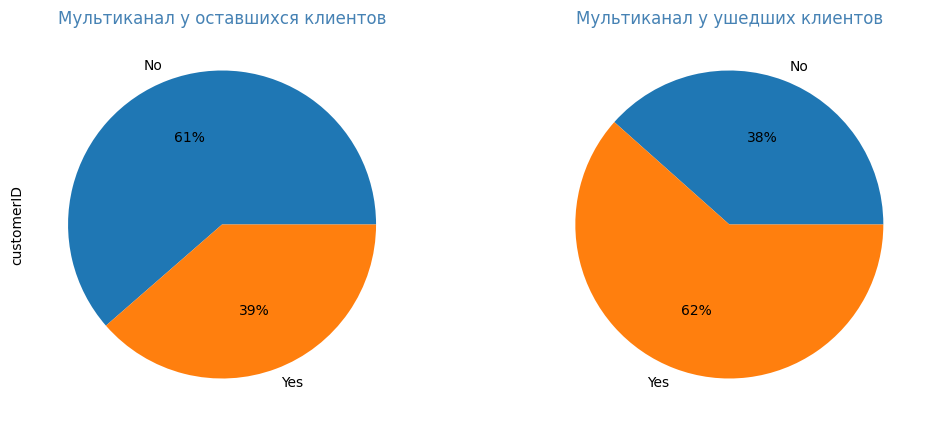

In [96]:
plt.figure(figsize=[12,5])
plt.subplot(1, 2, 1)

stayed.groupby('MultipleLines')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Мультиканал у оставшихся клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.subplot(1, 2, 2)
finished.groupby('MultipleLines')['customerID'].count().\
plot(kind = 'pie', legend = False, autopct = '%1.0f%%').set_title('Мультиканал у ушедших клиентов',
fontsize = 12,
color = 'SteelBlue')

plt.ylabel(None)

plt.show()

Мультиканал телефонной линии подключен у 62 % ушедших клиентов и у 39 % оставшихся.

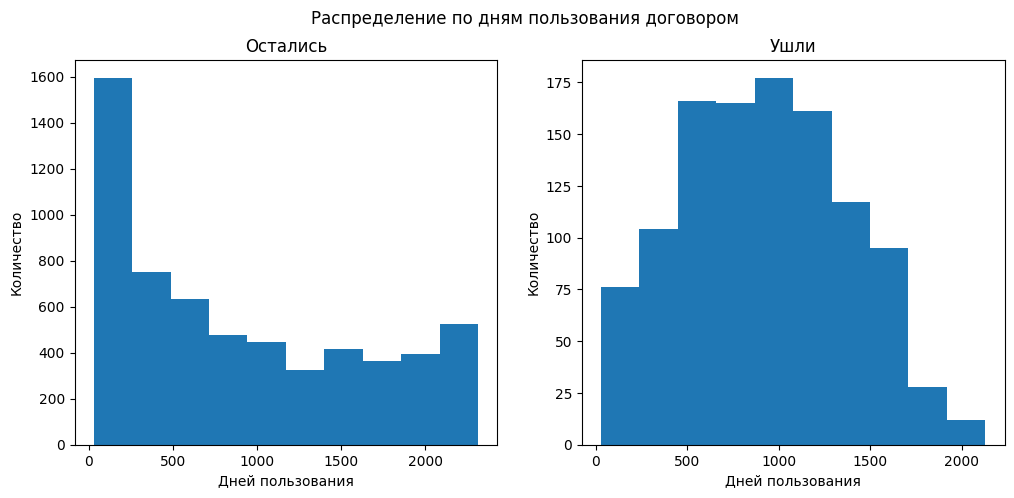

In [97]:
plt.subplots(figsize=(12, 5))
plt.suptitle('Распределение по дням пользования договором')

plt.subplot(1, 2, 1)
plt.hist(stayed['days'])
plt.title('Остались')
plt.xlabel('Дней пользования')
plt.ylabel('Количество')
 
plt.subplot(1, 2, 2)
plt.hist(finished['days'])
plt.title('Ушли')
plt.xlabel('Дней пользования')
plt.ylabel('Количество')

plt.show()

По дням пользования договором выявлено следующее:
- наблюдается явный пик у стоавшихся клиентов, они пользуются услугами до года
- также наблюдается пик у ушеших клиентов, большинство ушедших пользовалось услугами 3 года.

In [98]:
cols_numeric = ['MonthlyCharges', 'TotalCharges', 'target', 'days']
data_phik = data[cols_numeric]
data_phik.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'target', 'days']


,MonthlyCharges,TotalCharges,target,days
MonthlyCharges,1.000000,0.710944,0.225591,0.387365
TotalCharges,0.710944,1.000000,0.303758,0.847572
target,0.225591,0.303758,1.000000,0.374101
days,0.387365,0.847572,0.374101,1.000000


In [99]:
data.corr()

,MonthlyCharges,TotalCharges,SeniorCitizen,target,days
MonthlyCharges,1.000000,0.630297,0.219874,0.153927,0.218955
TotalCharges,0.630297,1.000000,0.093383,0.051548,0.821442
SeniorCitizen,0.219874,0.093383,1.000000,0.056444,0.004384
target,0.153927,0.051548,0.056444,1.000000,0.015716
days,0.218955,0.821442,0.004384,0.015716,1.000000


Сильной корреляции не наблюдается.

**Вывод**

По исследовательскому анализу объедиенных данных выявлено следующее:
- 16 % клиентов растогрнули договор обслуживания, в компании правы нужно проводить с этим работу.
-   Наблюдается очень плохая динамика, ушли в первую очередь клиенты заключившие договора в 2014 года, при этом большинство ушедших клиентов  пользовались услугами связи с 2014 по 2017 год. Возможно это связано с устареванием оборудования у этих клиентов и ухудшением связи.Остались же большинство новых клиентов, заключивших договора 2019-2020 годы. Думаю это связано с какой-то рекламной акцией. Также не стоит забывать внешние факторы в этот момент, такие как пандемия и перевод сотрудников на удаленную работу. Нужно связаться с заказчиком для уточнения этих предположений.
- В распределении по типам оплаты наблюдается следующее:
    - Ушли одинаково клиенты с оплатами ежемесячно, раз в год и раз в два года.
    - Остались большинство клиенты с оплатой ежемесячно.
- Получатели электронных счетов примерно поровну распределились для оставшихся клиентов и ушедших.
- Виды оплаты счетов распределились следующим образом:
    - Большиство оставшихся клиентов предпочитают оплату по электронному чеку их доля составляет 34 %, второе место занимает оплата по почте 25 % от общего числа.
    - У ушедших клиентов также большинство предпочитает оплату по электронному чеку их доля составляет 32 %, в то же время на втором месте расположились оплаты по кредитным и банковским картам с долей 29 % каждый. Оплата по почте занимает 11 %. Думаю это доказывает теорию выше, ушедшие клиенты более продвинуты и пользуются технологическими преимуществами, и их вероятно не устраивает текущие возможности связи провайдера.
- По ежемесячным платежам можно сказать следующее:
    - Наблюдается 2 пика по платежам у ушедших и оставшихся клиентов 20-30 и 80-100. Вероятно это связано с такифами заказчика.
    - Остались большинство клиетов с минимальной оплатой.
    - Ушли большинство клиентов с максимальной оплатой. Возможно на рынке появился конкурент, предлагающий те же услуги но дешевле, если это так, то стоит над этим подумать. Нужно обратиться в отдел маркетинга заказчика.
- По общим платежам наблюдается явная тенденция, остались клиенты которые заплатили до 2000. Ранее же писал, что большинство ушло большинство "старых" клиентов. А за большой период и сумма будет больше.
- Не наблюдается особой тенденции в различии по полу клиентов, примерно одинаково мужчин и женщин остались и также ушло.
- По возрасту видно следующее:
    - среди оставшихся клиентов 15 % пенсионеры,
    - среди ушедших клиентов 21 % пенсионеров.
- По семейному положению выявлено следующее:
    - среди оставшихся клиентов 55 % не состоят в браке.
    - а среди ушедших клиентов 65 % в браке, думаю стоит над этим подумать и предложить семейным какие-то особые условия или бонусную программу.
- По наличию детей у клиентов особой разницы не наблюдается, у 29 % оставшихся клиентов есть дети, и у 33 % ушедших тоже есть дети.
- Не все клиенты пользуются подключением, появилась новая категория не пользующуюся услугами связи. Возможно эти клиенты пользуются интернет услугами заказчиками, в то же время как они пользуются услугами связи другого провайдера. Стоит обратить на этих клиентов внимание и предложить свои услуги связи. Таже замечено, что большинство ушедших клиентов пользуется оптической связью и они составляют 54 % от общего количества ушедших клиентов.
- Блокировка вредоносных сайтов подключена у 27 % оставшихся клиентов и у 38 % ушедших клиентов.
- Облачное хранилище подключено у 51 % ушедших клиентов и у 31 % оставшихся клиентов.
- Антивирус подключен у 50 % ушедших клиентов и у 31 % оставшихся клиентов.
- Выделенная линия техподдержки подключена у 36 % ушедших клиентов и у 28 % оставшихся.
- Стриминговое ТВ водключено у 53 % ушедших клиентов и у 36 % оставшихся.
- Каталог фильмов подключен у 55 % ушедших клиентов и у 36 % оставшихся.
- Мультиканал телефонной линии подключен у 62 % ушедших клиентов и у 39 % оставшихся.
- По дням пользования договором выявлено следующее:
    - наблюдается явный пик у стоавшихся клиентов, они пользуются услугами до года
    - также наблюдается пик у ушеших клиентов, большинство ушедших пользовалось услугами 3 года.
- Стоит обратить внимание, что большинство ушедших клиентов пользовались дополнительными услугами. Из этого можно сделать вывод, что данные клиенты больше ценят качество, а следовательно стоит обратить внимание на качество и цену предоставляемых дополнительных услуг.
- Сильной корреляции в данных не наблюдается.

## Шаг 5. Подготовка данных

In [100]:
data.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,...,DSL,No,Yes,No,No,No,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.950001,2071.840088,Male,0,...,DSL,Yes,No,Yes,No,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2020-02-01,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,...,DSL,Yes,Yes,No,No,No,No,No,0,123
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,...,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2020-02-01,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,...,Fiber optic,No,No,No,No,No,No,No,0,153


Для построения модели нам нужно удалить даты из таблицы, т.к. они будут сильно искажать модель обучения.

In [101]:
data = data.drop('BeginDate', axis=1)

In [102]:
data = data.drop('EndDate', axis=1)

Переведем столбец customerID в индекс.

In [103]:
data = data.set_index('customerID')

In [104]:
data.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,target,days
customerID,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Month-to-month,Yes,Electronic check,29.850000,31.040001,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No,0,31
5575-GNVDE,One year,No,Mailed check,56.950001,2071.840088,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No,0,1036
3668-QPYBK,Month-to-month,Yes,Mailed check,53.849998,226.169998,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No,0,123
7795-CFOCW,One year,No,Bank transfer (automatic),42.299999,1960.599976,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No,0,1371
9237-HQITU,Month-to-month,Yes,Electronic check,70.699997,353.500000,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No,0,153


Выделяю признаки и целевой признак

In [105]:
X = data.drop('target', axis=1)
y = data['target']

In [106]:
X_train, X_test, y_train, y_test = train_test_split(
    X, 
    y, 
    test_size=0.25,
    random_state=RANDOM_STATE
)

In [107]:
X_train.shape, X_test.shape

((5274, 18), (1758, 18))

Выборка поделена на тренировочную и тестовую. Размерность соблюдена.

## Шаг 6. Обучение моделей машинного обучения

In [108]:
data.dtypes

Type                 object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float32
TotalCharges        float32
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
MultipleLines        object
target                int64
days                  int64
dtype: object

Проведем кодировку данных с помощью ColumnTransformer.

In [109]:
numerics = list(X.select_dtypes(include=['int64', 'float32']).columns)
categorical = list(X.select_dtypes(include='object').columns)

col_transformer = ColumnTransformer(
                        transformers=[
                            ('scaler', StandardScaler(), numerics),
                            ('ohe', OneHotEncoder(sparse=False, drop='first'), categorical)],
                                remainder="passthrough"
                                  )

col_transformer.fit(X_train)
X_train = col_transformer.transform(X_train)
X_test = col_transformer.transform(X_test)

Далее произведем обучение модели.

**LogisticRegression**

In [110]:
%%time

classificator = LogisticRegression(random_state = RANDOM_STATE)
parameters = {'C': np.linspace(0.01, 500, 5),'class_weight':['balanced']}

model_lr = GridSearchCV(estimator=LogisticRegression(),param_grid = parameters, n_jobs=-1,cv=CV_COUNTS, scoring='roc_auc')
model_lr.fit(X_train, y_train)
start = time()
model_lr.best_estimator_.fit(X_train, y_train)
end = time()
time_lr = (end-start)

mse_model_lr = model_lr.best_score_
print("Оптимальная комбинация гиперпараметров LogisticRegression:", model_lr.best_params_)
print()
print("ROC-AUC модели LogisticRegression:", mse_model_lr)

start1 = time()
preds_model_lr = model_lr.best_estimator_.predict_proba(X_train)[:, 1]

end1 = time()
time_lr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров LogisticRegression: {'C': 375.0025, 'class_weight': 'balanced'}

ROC-AUC модели LogisticRegression: 0.7745329650351048
CPU times: total: 297 ms
Wall time: 882 ms


**CatBoostClassifier**

In [ ]:
%%time
classificator = CatBoostClassifier(random_state = RANDOM_STATE)
hyperparams = {'max_depth': np.arange(4, 11),
                  'learning_rate':[0.01, 0.1, 1],
                  'iterations': [50,500,1000]}

model_cat = GridSearchCV(classificator, hyperparams, scoring='roc_auc',cv=CV_COUNTS, refit = 'roc_auc')
model_cat.fit(X_train, y_train)

start = time()
model_cat.best_estimator_.fit(X_train, y_train)
end = time()
time_cat = (end-start)

mse_model_cat = model_cat.best_score_
print("Оптимальная комбинация гиперпараметров CatBoostRegressor:", model_cat.best_params_)
print()
print("ROC-AUC модели CatBoostClassifier:", mse_model_cat)

start1 = time()
preds_model_cat = model_cat.best_estimator_.predict_proba(X_train)[:, 1]

end1 = time()
time_cat_pred = (end1-start1)

0:	learn: 0.6863807	total: 154ms	remaining: 7.55s
1:	learn: 0.6793598	total: 157ms	remaining: 3.78s
2:	learn: 0.6720766	total: 160ms	remaining: 2.51s
3:	learn: 0.6647369	total: 163ms	remaining: 1.87s
4:	learn: 0.6568959	total: 166ms	remaining: 1.49s
5:	learn: 0.6508608	total: 169ms	remaining: 1.24s
6:	learn: 0.6439967	total: 172ms	remaining: 1.05s
7:	learn: 0.6385112	total: 174ms	remaining: 913ms
8:	learn: 0.6323205	total: 177ms	remaining: 804ms
9:	learn: 0.6256021	total: 179ms	remaining: 717ms
10:	learn: 0.6200286	total: 182ms	remaining: 646ms
11:	learn: 0.6149494	total: 185ms	remaining: 585ms
12:	learn: 0.6089051	total: 188ms	remaining: 534ms
13:	learn: 0.6038604	total: 190ms	remaining: 489ms
14:	learn: 0.5982943	total: 193ms	remaining: 450ms
15:	learn: 0.5926368	total: 196ms	remaining: 416ms
16:	learn: 0.5867621	total: 199ms	remaining: 385ms
17:	learn: 0.5809005	total: 201ms	remaining: 358ms
18:	learn: 0.5759582	total: 204ms	remaining: 333ms
19:	learn: 0.5714549	total: 207ms	remaini

**DecisionTreeClassifier**

In [120]:
%%time
classificator = DecisionTreeClassifier(random_state=RANDOM_STATE)
hyperparams = [{'max_depth':[x for x in range(5,10,2)],
                'class_weight':['balanced']}]


model_tr = GridSearchCV(classificator, hyperparams, scoring='roc_auc',cv=CV_COUNTS)
model_tr.fit(X_train, y_train)

start = time()
model_tr.best_estimator_.fit(X_train, y_train)
end = time()
time_tr = (end-start)

mse_model_tr = model_tr.best_score_
print("Оптимальная комбинация гиперпараметров DecisionTreeRegressor:", model_tr.best_params_)
print()
print("ROC-AUC модели DecisionTreeRegressor:", mse_model_tr)

start1 = time()
preds_model_tr = model_tr.best_estimator_.predict_proba(X_train)[:, 1]

end1 = time()
time_tr_pred = (end1-start1)

Оптимальная комбинация гиперпараметров DecisionTreeRegressor: {'class_weight': 'balanced', 'max_depth': 5}

ROC-AUC модели DecisionTreeRegressor: 0.7854630213139746
CPU times: total: 281 ms
Wall time: 285 ms


Создадим новую табличку, где укажем время обучения, время предсказания и метрику ROC-AUC используемых моделей.

In [121]:
toxic = [[time_lr, time_lr_pred, mse_model_lr],
        [time_cat, time_cat_pred, mse_model_cat],
        [time_tr, time_tr_pred, mse_model_tr]]
model_toxic = ["LogisticRegression", "CatBoostClassifier", "DecisionTreeRegressor"]
scores_data = pd.DataFrame(data=toxic, index=model_toxic, columns=["fit_time", "predict_time", "ROC-AUC"])
scores_data['Выполнение задачи'] = scores_data['ROC-AUC'] > 0.85
scores_data

,fit_time,predict_time,ROC-AUC,Выполнение задачи
LogisticRegression,0.038972,0.000999,0.774533,False
CatBoostClassifier,2.942243,0.048966,0.922445,True
DecisionTreeRegressor,0.012991,0.001000,0.785463,False


Лучшей моделью с показателем ROC-AUC 0.922 является CatBoostRegressor со следующими гиперпараметрами {'iterations': 1000, 'learning_rate': 0.1, 'max_depth': 4}. Данную модель будем использовать на тестовых данных.

## Шаг 7. Выбор лучшей модели

Лучшей моделью с показателем ROC-AUC 0.922 является CatBoostRegressor, ее и будем использовать на тестовых данных.

In [122]:
%%time
start = time()
y_pred_proba = model_cat.best_estimator_.predict_proba(X_test)[:, 1]
end = time()
time_lr_pred1 = (end-start)

CPU times: total: 15.6 ms
Wall time: 19 ms


In [123]:
auc_roc = roc_auc_score(y_test, y_pred_proba)
print('ROC-AUC на тестовых данных:', round(auc_roc, 2))

ROC-AUC на тестовых данных: 0.92


ROC-AUC на тестовых данных: 0.92, что является проходным для критерия заказчика ROC-AUC>=0.85.

Постороим ROC-кривую.

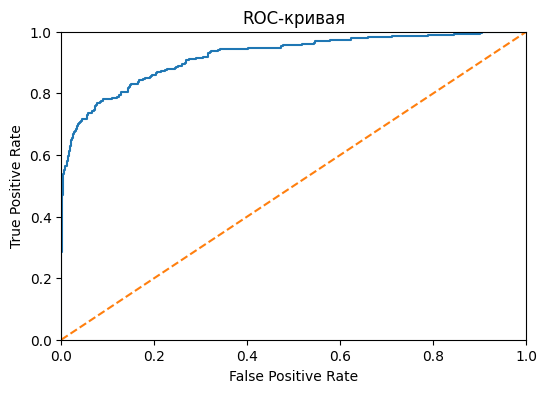

In [124]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr)
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')

plt.show()

Построим confusion_matrix.

In [125]:
predictions = model_cat.best_estimator_.predict(X_test)

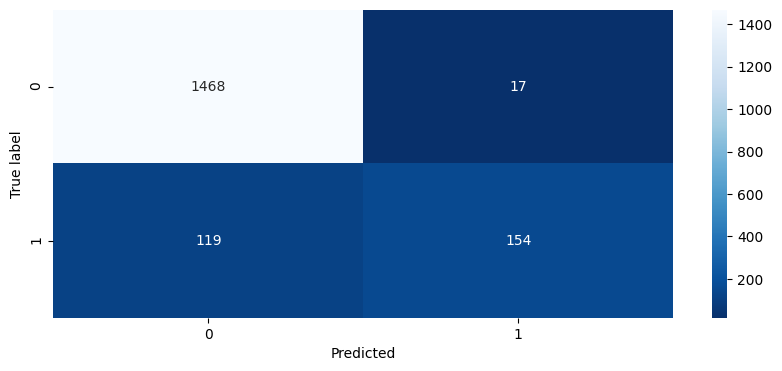

In [126]:
cm = metrics.confusion_matrix(y_test, predictions)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues_r')
plt.ylabel('True label')
plt.xlabel('Predicted');

,importance
feature,
days,54.163025
TotalCharges,10.804775
MonthlyCharges,10.488768
Type_Two year,4.051403
Partner_Yes,2.902170
Type_One year,2.104892
MultipleLines_Yes,1.968714
PaymentMethod_Mailed check,1.667430
OnlineBackup_Yes,1.512621


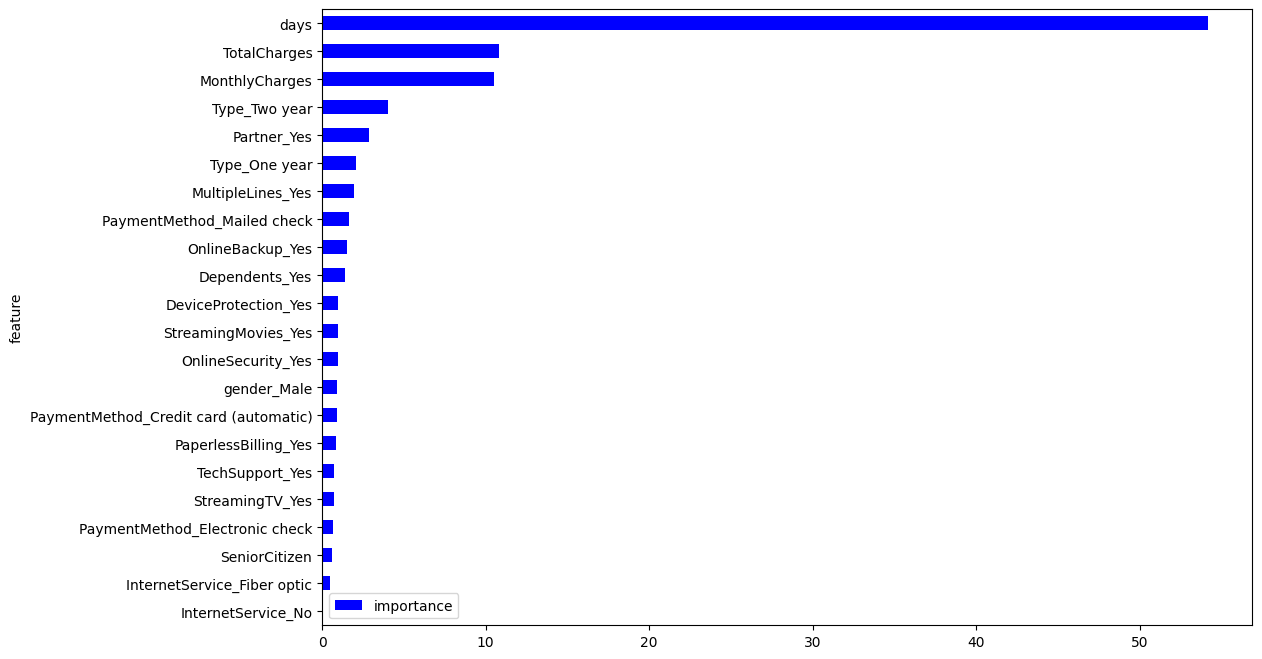

In [128]:
# исследуем важность признаков у ЛУЧШЕЙ модели

feature_names_numeric = numerics
feature_names_categorical = col_transformer.named_transformers_['ohe'].get_feature_names(categorical)
feature_names = feature_names_numeric + list(feature_names_categorical)

feature_importances = model_cat.best_estimator_.feature_importances_

# Сохранение результатов в DataFrame
fi_df = pd.DataFrame({'feature': feature_names,
                   'importance': feature_importances}) \
                    .sort_values('importance', ascending = True)

# Вывод важности признаков
fi_df.set_index('feature', inplace=True)

display(fi_df.sort_values(by='importance', ascending=False))

fi_df.plot.barh(color = 'blue', figsize=(12, 8));

    Наиболее важным признаком является столбец days со значением 54.163025, который показывает количество дней пользования услугами. Про данный фактор уже описано выше.
    Вторым по важности является значение MonthlyCharges = 10.804775, как ни крути, а ежемесячный платеж важен.
    Третьим является столбец TotalCharges = 10.488768, ну данный столбец связан со сроком пользования услуг, чем больше срок, тем больше клиент заплатит.
    Четвертым показателем Type_Two year - 4.051403.
    Пятым Partner_Yes	2.902170
    Шестым Type_One year	2.104892
    Седьмым MultipleLines_Yes	1.968714
    Восьмым PaymentMethod_Mailed check	1.667430
    Девятым OnlineBackup_Yes	1.512621
    Десятым Dependents_Yes	1.424442
    Одиннадцатым DeviceProtection_Yes	1.003179
    Двенадцатым StreamingMovies_Yes	0.992479
    Тринадцатым OnlineSecurity_Yes	0.962698
    Шестнадцатым gender_Male	0.941453
    Семнадцатым PaymentMethod_Credit card (automatic)	0.887753
    Восемнадцатым PaperlessBilling_Yes	0.844702
    Девятнадцатым TechSupport_Yes	0.743052
    Двадцатым StreamingTV_Yes	0.734716
    Двадцать первым PaymentMethod_Electronic check	0.700869
    Двадцать вторым SeniorCitizen	0.602191
    Двадцать третьим InternetService_Fiber optic	0.478204
    Двадцать четвертым InternetService_No	0.020467

## Шаг 8. Общий вывод и рекомендации заказчику

По итогам проведенной работы можно сделать следующие выводы:
1. После загрузки данных было выявлено следующее:
- В информации о договоре:
    - Столбцы MonthlyCharges и TotalCharges были приведены к формату float32. При этом в столбце TotalCharges были выявлены пробелы. Данные пробелы образовались из-за того, что клиенты только пришли и не успели заплатить за услуги связи. Такх строк было 11 и они были удалены из данных.
    - все данные уникальные, ошибок в заполнении граф не выявлено.
- В персональных данных клиента ошибки в заполнении граф не выявлены.
- В информации об интернет-услугах ошибок в заполнении не выявлено.
- В информации об услугах телефонии также ошибок в заполнении данных не выявлено.
2. Мы произвели объедение данных, к таблице с данными о договорах, где были удалены строки с пробелами, были присоеденены данные о клиентах, интернет услугах и многоканальности телефонной линии. Данные объедены без потерь получилось 7032 строк и 20 столбцов. Появились пропуски данных.
3. По исследовательскому анализу объедиенных данных выявлено следующее:
- 16 % клиентов растогрнули договор обслуживания, в компании правы нужно проводить с этим работу.
-   Наблюдается очень плохая динамика, ушли в первую очередь клиенты заключившие договора в 2014 года, при этом большинство ушедших клиентов  пользовались услугами связи с 2014 по 2017 год. Возможно это связано с устареванием оборудования у этих клиентов и ухудшением связи.Остались же большинство новых клиентов, заключивших договора 2019-2020 годы. Думаю это связано с какой-то рекламной акцией. Также не стоит забывать внешние факторы в этот момент, такие как пандемия и перевод сотрудников на удаленную работу. Нужно связаться с заказчиком для уточнения этих предположений.
- В распределении по типам оплаты наблюдается следующее:
    - Ушли одинаково клиенты с оплатами ежемесячно, раз в год и раз в два года.
    - Остались большинство клиенты с оплатой ежемесячно.
- Получатели электронных счетов примерно поровну распределились для оставшихся клиентов и ушедших.
- Виды оплаты счетов распределились следующим образом:
    - Большиство оставшихся клиентов предпочитают оплату по электронному чеку их доля составляет 34 %, второе место занимает оплата по почте 25 % от общего числа.
    - У ушедших клиентов также большинство предпочитает оплату по электронному чеку их доля составляет 32 %, в то же время на втором месте расположились оплаты по кредитным и банковским картам с долей 29 % каждый. Оплата по почте занимает 11 %. Думаю это доказывает теорию выше, ушедшие клиенты более продвинуты и пользуются технологическими преимуществами, и их вероятно не устраивает текущие возможности связи провайдера.
- По ежемесячным платежам можно сказать следующее:
    - Наблюдается 2 пика по платежам у ушедших и оставшихся клиентов 20-30 и 80-100. Вероятно это связано с такифами заказчика.
    - Остались большинство клиетов с минимальной оплатой.
    - Ушли большинство клиентов с максимальной оплатой. Возможно на рынке появился конкурент, предлагающий те же услуги но дешевле, если это так, то стоит над этим подумать. Нужно обратиться в отдел маркетинга заказчика.
- По общим платежам наблюдается явная тенденция, остались клиенты которые заплатили до 2000. Ранее же писал, что большинство ушло большинство "старых" клиентов. А за большой период и сумма будет больше.
- Не наблюдается особой тенденции в различии по полу клиентов, примерно одинаково мужчин и женщин остались и также ушло.
- По возрасту видно следующее:
    - среди оставшихся клиентов 15 % пенсионеры,
    - среди ушедших клиентов 21 % пенсионеров.
- По семейному положению выявлено следующее:
    - среди оставшихся клиентов 55 % не состоят в браке.
    - а среди ушедших клиентов 65 % в браке, думаю стоит над этим подумать и предложить семейным какие-то особые условия или бонусную программу.
- По наличию детей у клиентов особой разницы не наблюдается, у 29 % оставшихся клиентов есть дети, и у 33 % ушедших тоже есть дети.
- Не все клиенты пользуются подключением, появилась новая категория не пользующуюся услугами связи. Возможно эти клиенты пользуются интернет услугами заказчиками, в то же время как они пользуются услугами связи другого провайдера. Стоит обратить на этих клиентов внимание и предложить свои услуги связи. Таже замечено, что большинство ушедших клиентов пользуется оптической связью и они составляют 54 % от общего количества ушедших клиентов.
- Блокировка вредоносных сайтов подключена у 27 % оставшихся клиентов и у 38 % ушедших клиентов.
- Облачное хранилище подключено у 51 % ушедших клиентов и у 31 % оставшихся клиентов.
- Антивирус подключен у 50 % ушедших клиентов и у 31 % оставшихся клиентов.
- Выделенная линия техподдержки подключена у 36 % ушедших клиентов и у 28 % оставшихся.
- Стриминговое ТВ водключено у 53 % ушедших клиентов и у 36 % оставшихся.
- Каталог фильмов подключен у 55 % ушедших клиентов и у 36 % оставшихся.
- Мультиканал телефонной линии подключен у 62 % ушедших клиентов и у 39 % оставшихся.
- По дням пользования договором выявлено следующее:
    - наблюдается явный пик у стоавшихся клиентов, они пользуются услугами до года
    - также наблюдается пик у ушеших клиентов, большинство ушедших пользовалось услугами 3 года.
- Стоит обратить внимание, что большинство ушедших клиентов пользовались дополнительными услугами. Из этого можно сделать вывод, что данные клиенты больше ценят качество, а следовательно стоит обратить внимание на качество и цену предоставляемых дополнительных услуг.
- Сильной корреляции в данных не наблюдается.
4. Выборка поделена на тренировочную и тестовую. Размерность соблюдена.
5. Лучшей моделью с показателем ROC-AUC 0.922 является CatBoostRegressor со следующими гиперпараметрами {'iterations': 1000, 'learning_rate': 0.1, 'max_depth': 4}. Данную модель будем использовать на тестовых данных.
6. ROC-AUC на тестовых данных: 0.92, что является проходным для критерия заказчика ROC-AUC>=0.85.

    Наиболее важным признаком является столбец days со значением 54.163025, который показывает количество дней пользования услугами. Про данный фактор уже описано выше.
    Вторым по важности является значение MonthlyCharges = 10.804775, как ни крути, а ежемесячный платеж важен.
    Третьим является столбец TotalCharges = 10.488768, ну данный столбец связан со сроком пользования услуг, чем больше срок, тем больше клиент заплатит.
    Четвертым показателем Type_Two year - 4.051403.
    Пятым Partner_Yes	2.902170
    Шестым Type_One year	2.104892
    Седьмым MultipleLines_Yes	1.968714
    Восьмым PaymentMethod_Mailed check	1.667430
    Девятым OnlineBackup_Yes	1.512621
    Десятым Dependents_Yes	1.424442
    Одиннадцатым DeviceProtection_Yes	1.003179
    Двенадцатым StreamingMovies_Yes	0.992479
    Тринадцатым OnlineSecurity_Yes	0.962698
    Шестнадцатым gender_Male	0.941453
    Семнадцатым PaymentMethod_Credit card (automatic)	0.887753
    Восемнадцатым PaperlessBilling_Yes	0.844702
    Девятнадцатым TechSupport_Yes	0.743052
    Двадцатым StreamingTV_Yes	0.734716
    Двадцать первым PaymentMethod_Electronic check	0.700869
    Двадцать вторым SeniorCitizen	0.602191
    Двадцать третьим InternetService_Fiber optic	0.478204
    Двадцать четвертым InternetService_No	0.020467